# Environment

In [1]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,73,74]
      no_down = lambda s: s in [23,24,54]
      no_left = lambda s: s in [44,35,54,65]
      no_right = lambda s: s in [32,42,52,62]

      #Barries in the path
      pit = lambda s: s in [13,72,41]
      wall = lambda s: s in [43,33,53,34,64,63]

      #Rewards of each state
      reward = 3.0 if is_done(s) else 0.0
      reward = -15.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -5.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -5.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -5.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -5.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,72,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,72,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,64,63]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

### How to use the above class? ###

In [2]:
env =  GridworldEnv()
env.reset()
env._render()

for _ in range(4):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # Take a random action
    print(info)
    print('action:',action)
    env._render()
env.close()


       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
{'prob': 1.0}
action: 3
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    . 

#### In google colab you may need to install the below library.

In [3]:
!pip install colorama

In this project, we want to get more rewards in the game that define in the up code. For this purpose, we implement 6 algorithms.
1. On-policy monte-carlo
2. Off-policy monte-carlo
3. Double Q-learning
4. Tree Back-up(with n=1, 2, 3)
5. SARSA
6. Two-step Expected SARSA

For each of this algorithms, we plot reward per episode and compare them with each other. And with this plots, we compare algorithms learning rates with each other.

# Algorithms
## On-policy Monte-carlo

Run time: 18.34175205230713
Average Reward: -11.975
Test Average Reward: 3.0


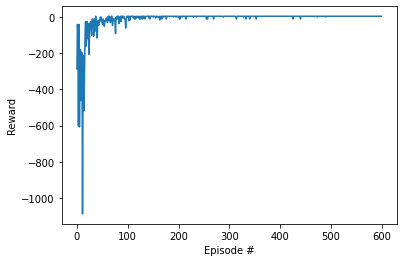

In [216]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt

epsilon = 1
env.reset()

actions_count = env.nA
states_count = env.nS
policy = [[1/actions_count for _ in range(actions_count)] for _ in range(states_count)]
q = [[0 for _ in range(actions_count)] for _ in range(states_count)]
returns = [[list() for _ in range(actions_count)] for _ in range(states_count)]

EPISODES_COUNT = 600
FINAL_STATE_REWARD = 3

def generate_episode(environment, policy, step_counts=math.inf):
    environment.reset()
    state = 44
    states = []
    actions = []
    rewards = []
    steps = 0
    while steps < step_counts:
        steps += 1
        states.append(state)
        action = np.random.choice(range(actions_count), p=policy[state])
        state, reward, done, info = env.step(action)
        actions.append(action)
        rewards.append(reward)
        if reward == FINAL_STATE_REWARD:
            break
    return states, actions, rewards

def is_state_action_exists_in_sequence(t, states, actions):
    state, action = states[t], actions[t]
    for index in range(t-1, -1, -1):
        if state == states[index] and action == actions[index]:
            return True
    return False
    
episode_rewards = []
start_time = time.time()
for _ in range(EPISODES_COUNT):
    states, actions, rewards = generate_episode(env, policy)
    episode_rewards.append(sum(rewards))
    episode_length = len(states)
    g = 0
    for t in range(episode_length-1, -1, -1):
        g += rewards[t]
        state, action = states[t], actions[t]
        if not is_state_action_exists_in_sequence(t, states, actions):
            returns[state][action].append(g)
            q[state][action] = np.mean(returns[state][action])
            best_action = np.argmax(q[state])
            state_policy = policy[state]
            for action in range(actions_count):
                if action == best_action:
                    state_policy[action] = 1 - epsilon + (epsilon / actions_count)
                else:
                    state_policy[action] = epsilon / actions_count
    epsilon *= 0.99
TEST_EPISODES_COUNT = 20
test_rewards = []
for _ in range(TEST_EPISODES_COUNT):
    states, actions, rewards = generate_episode(env, policy)
    test_rewards.append(sum(rewards))
    episode_length = len(states)
    g = 0
    for t in range(episode_length-1, -1, -1):
        g += rewards[t]
        state, action = states[t], actions[t]
        if not is_state_action_exists_in_sequence(t, states, actions):
            returns[state][action].append(g)
            q[state][action] = np.mean(returns[state][action])
            best_action = np.argmax(q[state])
            state_policy = policy[state]
            for action in range(actions_count):
                if action == best_action:
                    state_policy[action] = 1 - epsilon + (epsilon / actions_count)
                else:
                    state_policy[action] = epsilon / actions_count
end_time = time.time()
print("Run time: {}".format(end_time - start_time))
print("Average Reward: {}".format(np.average(episode_rewards)))
print("Test Average Reward: {}".format(np.average(test_rewards)))
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episode_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

As we see, It's learn properly because test average reward is 3 and it's very goof because our algorithm skip all obstacles and doesn't get any negative reward.

As we see in plot, it converges after 100 episodes approximately.

## Off-policy Monte-Carlo

Run time: 1.0602469444274902
[-157.0, -592.0, -957.0, -52.0, -327.0, -247.0, -137.0, -92.0, -107.0, -147.0, -217.0, -32.0, -72.0, -12.0, -157.0, -77.0, -132.0, -47.0, -17.0, -82.0, -62.0, -2.0, -102.0, -57.0, -87.0, -12.0, -27.0, -32.0, -77.0, -37.0, -27.0, -22.0, -2.0, -87.0, -62.0, -32.0, -22.0, -2.0, -17.0, -52.0, -2.0, -47.0, -57.0, -2.0, -17.0, -7.0, -12.0, -42.0, -42.0, -62.0, -62.0, -107.0, -7.0, -2.0, 3.0, -87.0, -67.0, -107.0, -97.0, -32.0, -67.0, -137.0, -2.0, -92.0, -92.0, -7.0, -52.0, -7.0, -57.0, -17.0, -232.0, -37.0, -77.0, -12.0, -102.0, -47.0, -67.0, -7.0, -7.0, -2.0, -2.0, 3.0, -27.0, -12.0, -107.0, -107.0, -77.0, -12.0, -17.0, -12.0, -117.0, -17.0, -12.0, 3.0, -2.0, -12.0, -12.0, -92.0, -112.0, -157.0, -37.0, -162.0, 3.0, -132.0, -2.0, -17.0, -7.0, -77.0, 3.0, -7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -42.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.

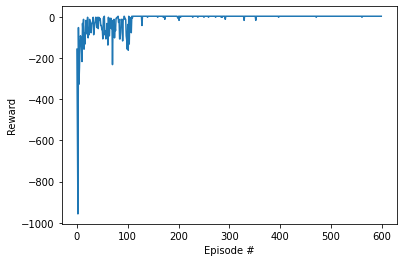

In [217]:
q = [[0 for _ in range(actions_count)] for _ in range(states_count)]
c = [[0 for _ in range(actions_count)] for _ in range(states_count)]
policy = [0 for _ in range(states_count)]
epsilon = 1
initial_state = 44
discount_factor = 0.9
env.reset()
episode_rewards = []
start_time = time.time()
for _ in range(EPISODES_COUNT):
    behavior = [[epsilon / actions_count for _ in range(actions_count)] for _ in range(states_count)]
    for state in range(states_count):
        best_action = np.argmax(q[state])
        behavior[state][best_action] += (1 - epsilon)
    states, actions, rewards = generate_episode(env, behavior)
    episode_rewards.append(sum(rewards))
    g = 0.0
    w = 1.0
    episode_length = len(states)
    for t in range(episode_length-1, -1, -1):
        state, action = states[t], actions[t]
        g = g * discount_factor + rewards[t]
        c[state][action] += w
        q[state][action] += ((w / c[state][action])*(g - q[state][action]))
        policy[state] = np.argmax(q[state])
        if policy[state] != action:
            break
        w *= (1 / behavior[state][action])
    epsilon *= 0.99
end_time = time.time()
env.reset()
state = 44
states = []
test_rewards = []
while True:
    states.append(state)
    action = policy[state]
    state, reward, done, info = env.step(action)
    test_rewards.append(sum(rewards))
    if reward == FINAL_STATE_REWARD:
        break
print("Run time: {}".format(end_time - start_time))
print(episode_rewards)
print("Average Reward: {}".format(np.average(episode_rewards)))
print("Test average reward: {}".format(np.average(test_rewards)))
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episode_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

As we see, It's learn properly because test average reward is 3 and latest rewards are all 3. it's very good because our algorithm skip all obstacles and doesn't get any negative reward at the end (after learning). This algorithm learns greedy policy. because of that, just one test is enough because output always is constant.

As we see in plot, it converges after 100 episodes approximately but it has more up and downs than on policy. It's run time is less than on policy.

## Double Q-learning

Run time: 1.0547149181365967
Average Reward: -7.066666666666666
[-517.0, -12.0, -1057.0, -112.0, -457.0, -77.0, -532.0, -27.0, -172.0, -187.0, -22.0, -52.0, -192.0, -212.0, -102.0, -32.0, -27.0, -112.0, -52.0, -7.0, -62.0, -37.0, -67.0, -42.0, -2.0, -17.0, -62.0, -107.0, -112.0, -72.0, -7.0, -12.0, -27.0, -12.0, -27.0, 3.0, -27.0, -22.0, 3.0, -12.0, -12.0, -12.0, -67.0, -77.0, -2.0, -32.0, -7.0, 3.0, -57.0, -47.0, -22.0, -22.0, 3.0, 3.0, -7.0, -12.0, -42.0, -92.0, -27.0, -2.0, -12.0, -32.0, -7.0, -17.0, 3.0, -2.0, -12.0, -32.0, -2.0, 3.0, -12.0, -2.0, -12.0, 3.0, -12.0, 3.0, 3.0, -17.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, -2.0, 3.0, -2.0, 3.0, 3.0, -2.0, -12.0, 3.0, -17.0, 3.0, -12.0, 3.0, -2.0, 3.0, -7.0, -2.0, -12.0, 3.0, 3.0, -2.0, -27.0, 3.0, 3.0, 3.0, -27.0, 3.0, -7.0, 3.0, 3.0, 3.0, 3.0, -2.0, 3.0, -2.0, 3.0, 3.0, -2.0, -17.0, -2.0, 3.0, -2.0, -2.0, 3.0, -12.0, 3.0, 3.0, 3.0, -22.0, 3.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3

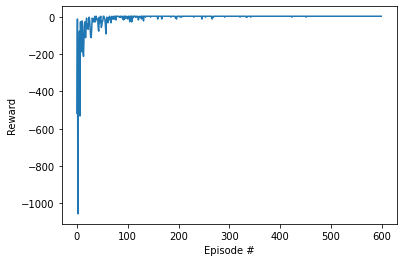

In [219]:
import random

env.reset()
epsilon = 1
alpha = 1
q1 = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
q2 = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
episodes_rewards = []
start_time = time.time()
for _ in range(EPISODES_COUNT):
    episode_reward = 0
    state = 44
    env.reset()
    while True:
        total_q = q1 + q2
        best_action = np.argmax(total_q[state])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action = np.random.choice(range(actions_count), p=probs)
        next_state, reward, _, _ = env.step(action)
        episode_reward += reward
        if random.random() < 0.5:
            q1[state][action] += (alpha * (reward + discount_factor * q2[next_state][np.argmax(q1[next_state])] - q1[state][action]))
        else:
            q2[state][action] += (alpha * (reward + discount_factor * q1[next_state][np.argmax(q2[next_state])] - q2[state][action]))
        state = next_state
        if reward == FINAL_STATE_REWARD:
            break
    episodes_rewards.append(episode_reward)
    epsilon *= 0.99
    alpha *= 0.99
end_time = time.time()
print("Run time: {}".format(end_time - start_time))
print("Average Reward: {}".format(np.average(episodes_rewards)))
print(episodes_rewards)
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episodes_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

This algorithm rewards converges to 3 at the end after learning phase. It has better average reward because this algorithm converges faster and get less bad rewards. At the end, our agent doesn't get stuck in any obstacle.

As you see in plot, it converges very faster in less than 100 episodes. It runs faster than two previous algorithms.

## Tree Back-up

One step time: 103.25141501426697
One step rewards:
[-462.0, -332.0, -462.0, -32.0, -57.0, -72.0, -82.0, -72.0, -57.0, -182.0, -7.0, -57.0, -62.0, -7.0, -102.0, -32.0, -57.0, -7.0, -2.0, -137.0, -67.0, -222.0, -267.0, -17.0, -67.0, -67.0, -22.0, -52.0, -47.0, -77.0, -2.0, -27.0, -82.0, -42.0, -27.0, -62.0, -12.0, -47.0, -27.0, -32.0, -17.0, -62.0, -17.0, -112.0, -12.0, -67.0, -152.0, -67.0, -32.0, -57.0, -87.0, -22.0, -92.0, 3.0, -12.0, 3.0, -12.0, -22.0, 3.0, -32.0, -32.0, -12.0, -12.0, -87.0, -107.0, -52.0, -2.0, -2.0, -77.0, 3.0, 3.0, -17.0, -17.0, -32.0, -62.0, -42.0, -7.0, -42.0, -137.0, -42.0, 3.0, -72.0, 3.0, -2.0, -12.0, -12.0, -42.0, 3.0, -57.0, -12.0, -12.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -77.0, -2.0, -27.0, -2.0, -42.0, -22.0, -17.0, -87.0, -27.0, -17.0, -17.0, -52.0, 3.0, -42.0, -122.0, -67.0, -32.0, -97.0, -77.0, -2.0, -32.0, 3.0, -12.0, -17.0, -57.0, -12.0, -42.0, -2.0, -47.0, 3.0, 3.0, -12.0, -12.0, 3.0, -47.0, -12.0, -42.0, -12.0, 3.0, -12.0, -12.0, -17.0, 3.0, 3.0, -12.

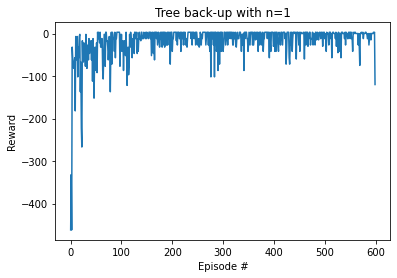

Two step time: 59.27485179901123
Two step rewards:
[-447.0, -262.0, -57.0, -47.0, -52.0, -67.0, -67.0, -52.0, -32.0, -222.0, -17.0, -157.0, -37.0, -27.0, -352.0, -77.0, -12.0, -27.0, -62.0, -192.0, -102.0, -42.0, -17.0, -72.0, -102.0, -27.0, -82.0, -32.0, -2.0, -22.0, -62.0, -42.0, -27.0, -172.0, -12.0, -67.0, 3.0, -62.0, -87.0, -67.0, -127.0, -87.0, -2.0, -17.0, -12.0, -12.0, -7.0, -17.0, -67.0, -37.0, -17.0, -27.0, -12.0, -7.0, -167.0, -12.0, -2.0, -132.0, -27.0, -12.0, -12.0, -2.0, -82.0, -27.0, -57.0, -127.0, -2.0, -17.0, -32.0, -12.0, -87.0, -12.0, -12.0, -37.0, -57.0, -52.0, -2.0, 3.0, -112.0, 3.0, -17.0, -42.0, -167.0, -12.0, -27.0, 3.0, -27.0, -12.0, 3.0, -77.0, -32.0, -17.0, -27.0, 3.0, -42.0, -57.0, -57.0, -12.0, 3.0, -17.0, -27.0, -12.0, -87.0, -47.0, -17.0, -12.0, -27.0, 3.0, -32.0, -82.0, -57.0, -27.0, -32.0, -12.0, -12.0, -12.0, 3.0, 3.0, -27.0, -27.0, 3.0, -12.0, -57.0, -87.0, -12.0, 3.0, -27.0, -12.0, -42.0, -12.0, -12.0, -72.0, -2.0, -2.0, 3.0, 3.0, -7.0, 3.0, 3.0, 3.0

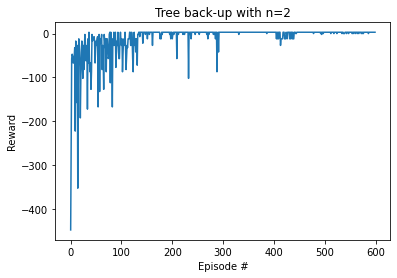

Three step time: 403.41983008384705
Three step rewards:
[-1422.0, -167.0, -27.0, -1007.0, -72.0, -547.0, -117.0, -57.0, -12.0, -12.0, -27.0, -52.0, -122.0, -17.0, -87.0, -92.0, -197.0, -157.0, -207.0, -27.0, -77.0, -117.0, -52.0, -62.0, -27.0, -32.0, -2.0, -72.0, -77.0, 3.0, -42.0, -47.0, -12.0, -82.0, -157.0, -7.0, 3.0, -32.0, -122.0, -7.0, -32.0, -42.0, -12.0, -17.0, -42.0, -2.0, -12.0, -167.0, -17.0, -12.0, -17.0, -17.0, -37.0, -32.0, -52.0, -2.0, -12.0, -47.0, -32.0, -12.0, -17.0, -7.0, -17.0, 3.0, 3.0, -12.0, -27.0, -27.0, -62.0, -2.0, -2.0, -42.0, -12.0, 3.0, -57.0, -17.0, -42.0, -17.0, 3.0, -12.0, -62.0, -7.0, -2.0, -12.0, -77.0, 3.0, -22.0, 3.0, -2.0, -12.0, -12.0, -12.0, -12.0, -12.0, -27.0, 3.0, 3.0, -12.0, -2.0, -12.0, -2.0, 3.0, -12.0, -12.0, -15.0, 0.0, -10.0, 3.0, 3.0, -20.0, -15.0, -32.0, 3.0, 0.0, -2.0, -12.0, 3.0, -2.0, 3.0, -37.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, -2.0, -2.0, 3.0, -17.0, 0.0, 0.0, -12.0, -5.0, 3.0, 3.0, -2.0, -12.0, -17.0, -2.0, 3.0, -52.0, 3.0, -2.0, 3.

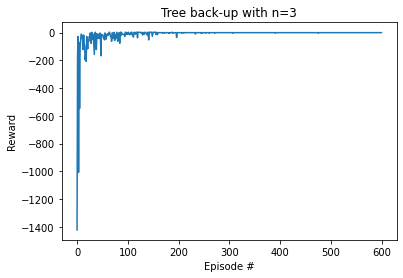

In [220]:
import math

def n_step_tree_backup(n):
    q = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
    epsilon = 1
    policy = [[epsilon/actions_count for _ in range(actions_count)] for _ in range(states_count)]
    for state in range(states_count):
        policy[state][np.argmax(q[state])] += (1 - epsilon)
    alpha = 1
    start_time = time.time()
    episodes_rewards = []
    for _ in range(600):
        step_counter = 0
        env.reset()
        state = 44
        states = [state]
        actions = []
        rewards = [0]
        action = np.random.choice(range(actions_count), p=policy[state])
        actions.append(action)
        T = math.inf
        index = 0
        tau = 0
        while tau + 1 < T and step_counter < 10000:
            step_counter += 1
            if index < T:
                state, reward, _, _ = env.step(action)
                states.append(state)
                rewards.append(reward)
                if reward == FINAL_STATE_REWARD:
                    T = index + 1
                else:
                    action = np.random.choice(range(actions_count), p=policy[state])
                    actions.append(action)
            tau = index + 1 - n
            if tau >= 0:
                if index + 1 >= T:
                    G = rewards[T]
                else:
                    actions_q = 0
                    for a in range(actions_count):
                        actions_q += (policy[states[index+1]][a]*q[states[index+1]][a])
                    G = rewards[index+1] + discount_factor * actions_q
                for_start = min(index, T-1)
                for k in range(for_start, tau, -1):
                    other_actions_q = 0
                    for a in range(actions_count):
                        if a != actions[k]:
                            other_actions_q += (policy[states[k]][a]*q[states[index]][a])
                    G = rewards[k] + discount_factor * other_actions_q + discount_factor * policy[states[k]][actions[k]] * G
                q[states[tau]][actions[tau]] += (alpha * (G - q[states[tau]][actions[tau]]))
                policy[states[tau]] = [epsilon / actions_count for _ in range(actions_count)]
                policy[states[tau]][np.argmax(q[states[tau]])] += (1-epsilon)
            index += 1
        alpha *= 0.99999999
        epsilon *= 0.99
        episodes_rewards.append(np.sum(rewards))
    total_time = time.time() - start_time
    return total_time, episodes_rewards

episdoes_number = [i for i in range(EPISODES_COUNT)]
one_total_time, one_rewards = n_step_tree_backup(1)
print("One step time: {}".format(one_total_time))
print("One step rewards:")
print(one_rewards)
plt.plot(episdoes_number, one_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.title("Tree back-up with n=1")
plt.show()
two_total_time, two_rewards = n_step_tree_backup(2)
print("Two step time: {}".format(two_total_time))
print("Two step rewards:")
print(two_rewards)
plt.plot(episdoes_number, two_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.title("Tree back-up with n=2")
plt.show()
three_total_time, three_rewards = n_step_tree_backup(3)
print("Three step time: {}".format(three_total_time))
print("Three step rewards:")
print(three_rewards)
plt.plot(episdoes_number, three_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.title("Tree back-up with n=3")
plt.show()

As you see the result, tree back-up algorithms get more time to run and they are slower than previous algorithms.
It converges not very good and get stuck in obstacles and some how can't reach to target in 10000 steps. We set up limit for steps to avoid get stuck in infinite loop. 

We can see in plot, our algorithm doesn't converges properly and oscilate very badly.

Tree back-up with n=2 has better run time and converges properly after 300 episodes approximately. After learning phase, it gets 3 rewards because it learns game and doesn't get stuck in obstacles. 

Tree back-up with n=3 get lot of time and it can't converges and needs a lot of steps for an episode and because of that can't reach target in many episodes. Before getting stuck in latest episodes, it reaches to target in some episodes. Tree back-up with this config isn't good with this limit and can't find the answer.

## SARSA

Total time: 3.9725759029388428
[-562.0, -347.0, -187.0, -92.0, -202.0, -247.0, -312.0, -177.0, -212.0, -157.0, -57.0, -32.0, -287.0, -152.0, -17.0, -147.0, -42.0, -97.0, -282.0, -97.0, -247.0, -377.0, -17.0, -82.0, -217.0, -102.0, -22.0, -92.0, -142.0, -67.0, -22.0, -2.0, -47.0, -52.0, -147.0, -122.0, -32.0, -12.0, 3.0, -72.0, -12.0, -12.0, -2.0, -12.0, -77.0, -17.0, -12.0, 3.0, -12.0, -27.0, -2.0, -2.0, -37.0, -32.0, -12.0, -2.0, 3.0, 3.0, 3.0, -17.0, -17.0, -2.0, -2.0, -17.0, -82.0, 3.0, 3.0, 3.0, -12.0, -2.0, -37.0, -32.0, 3.0, -12.0, -52.0, -27.0, -12.0, 3.0, -42.0, -12.0, 3.0, -2.0, -67.0, -27.0, -102.0, -27.0, -27.0, -17.0, -2.0, -27.0, -2.0, 3.0, -42.0, -12.0, -7.0, -7.0, -2.0, 3.0, -2.0, 3.0, -27.0, 3.0, 3.0, -2.0, -12.0, -27.0, 3.0, 3.0, 3.0, 3.0, -2.0, -2.0, -2.0, 3.0, 3.0, -12.0, -17.0, -2.0, 3.0, 3.0, 3.0, 3.0, -12.0, 3.0, -2.0, 3.0, 3.0, 3.0, -12.0, 3.0, -2.0, 3.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, -17.0, -2.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.

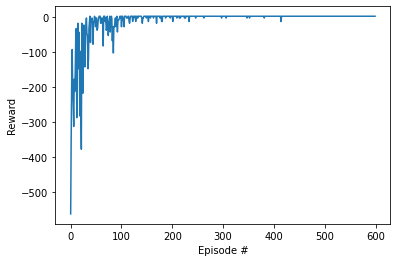

In [221]:
env.reset()
epsilon = 1
alpha = 1
q = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
start_time = time.time()
episodes_rewards = []
for _ in range(EPISODES_COUNT):
    env.reset()
    episode_rewards = []
    state = 44
    best_action = np.argmax(q[state])
    probs = [epsilon / actions_count for _ in range(actions_count)]
    probs[best_action] += (1-epsilon)
    action = np.random.choice(range(actions_count), p=probs)
    while True:
        state_prim, reward, _, _ = env.step(action)
        episode_rewards.append(reward)
        best_action = np.argmax(q[state_prim])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action_prim = np.random.choice(range(actions_count), p=probs)
        q[state][action] += (alpha * (reward + discount_factor * q[state_prim][action_prim] - q[state][action]))
        state = state_prim
        action = action_prim
        if reward == FINAL_STATE_REWARD:
            break
    episodes_rewards.append(np.sum(episode_rewards))
    epsilon *= 0.99
    alpha *= 0.999
end_time = time.time()
total_time = end_time - start_time
print("Total time: {}".format(total_time))
print(episodes_rewards)
print("SARSA average reward: {}".format(np.average(episode_rewards)))
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episodes_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

This algorithm has good run time. It's runtime is better than on policy and backup trees but it's slower than off policy and double q-learning.

It converges to find target at the end very strongly. It learns game after 100 episodes approximately. It records best average reward in all algorithms because it learns very soon and get less bad rewards.

## Two-Step Expected SARSA

Total time: 2.3258988857269287
[-57.0, -22.0, -7.0, -62.0, -372.0, -22.0, -97.0, -102.0, -87.0, -177.0, -97.0, -12.0, -202.0, -252.0, -412.0, -122.0, -77.0, -92.0, -42.0, -37.0, -217.0, -2.0, -42.0, -47.0, -12.0, -17.0, -57.0, -32.0, -147.0, -12.0, -27.0, -12.0, 3.0, -67.0, -92.0, -67.0, -17.0, -132.0, 3.0, -52.0, -42.0, -87.0, -32.0, 3.0, -2.0, -22.0, 3.0, -32.0, -12.0, -2.0, -12.0, -7.0, 3.0, -92.0, -67.0, -12.0, -12.0, 3.0, 3.0, 3.0, 3.0, 3.0, -2.0, 3.0, -2.0, -2.0, -2.0, -12.0, -27.0, -2.0, -2.0, 3.0, -7.0, 3.0, 3.0, -2.0, -32.0, 3.0, 3.0, -7.0, -17.0, -2.0, -2.0, -12.0, -2.0, -32.0, -2.0, -7.0, -57.0, -62.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -17.0, 3.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.0, -32.0, -2.0, -17.0, -7.0, -22.0, -2.0, 3.0, -2.0, -2.0, -17.0, -12.0, 3.0, 3.0, -42.0, 3.0, 3.0, -2.0, 3.0, 3.0, -2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -17.0, 3.0, 3.0, -12.0, -32.0, -7.0, 3.0, 3.0, 3.0, 3.0, -12.0, -2.0, -12.0, 3.0, -17.0, 3.0, 3.0, -2.0, -12.0, -2.0, 3.0, 3.0, 3.0, -27.0, 3.0, 3.0, -12.0, 

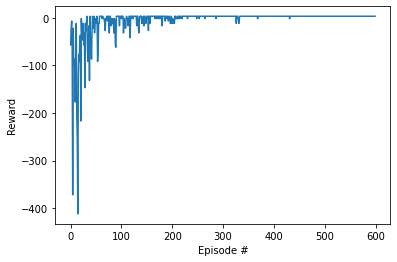

In [222]:
env.reset()
epsilon = 1
alpha = 1
q = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
start_time = time.time()
episodes_rewards = []
for _ in range(EPISODES_COUNT):
    env.reset()
    episode_rewards = []
    state = 44
    while True:
        best_action = np.argmax(q[state])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action = np.random.choice(range(actions_count), p=probs)
        state_prim, reward, _, _ = env.step(action)
        best_action = np.argmax(q[state_prim])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action_2 = np.random.choice(range(actions_count), p=probs)
        state_zeg, reward_2, _, _ = env.step(action_2)
        episode_rewards.append(reward)
        best_action = np.argmax(q[state_zeg])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        expected_q = 0
        for a in range(actions_count):
            expected_q += probs[a]*q[state_zeg][a]
        q[state][action] += (alpha * (reward + discount_factor * reward_2 + (discount_factor**2) * expected_q - q[state][action]))
        state = state_prim
        if reward == FINAL_STATE_REWARD:
            break
    episodes_rewards.append(np.sum(episode_rewards))
    epsilon *= 0.99
    alpha *= 0.9999999
end_time = time.time()
total_time = end_time - start_time
print("Total time: {}".format(total_time))
print(episodes_rewards)
print("Two-step Expected SARSA average reward: {}".format(np.average(episode_rewards)))
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episodes_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

This algorithms records acceptable run time. It is better than SARSA because it's get expected return instead of summing over all actions. But it's run time is a little worse than off policy and double Q-learning. 

It converges to target very fast. After learning game, it's reward is always 3 because it's never get stuck or hit obstacle. Because of that it's very good.

It records best averge reward in compare with other 5 algorithms. Its reason is high learning rate of this algorithm in compare with other algorithms. It gets less punishments(negative rewards).

It converges, after 100 episodes approximately as we see in plot.

## Learning speed compare

If we see speed as less time for running 600 episodes, our ranking is like below:
1. Double Q-learning
2. Off-policy MC
3. Two-Step Expected SARSA
4. SARSA 
5. On-policy MC
6. Tree back-up with n=2
7. Tree back-up with n=1
8. Tree back-up with n=3

Double Q-learning runs very fast because eliminate the harm caused by maximization bias.
Tree back-ups runs very slowly becuase they can't reach to target and get stuck.

If we see speed as less episodes to get target reward in one episode, our ranking is like below:
1. Two-Step Expected SARSA
2. SARSA
3. Double Q-learning
4. Off-policy MC
5. On-policy MC
6. Tree back-up with n=2
- Tree back-up with n=1
- Tree back-up with n=3

This rankings achieved by observing, reward vs. episode # plots and average rewards in all episodes.
If some algorithm converges to good policy(policy that reaches target) and gets less bad rewards, it means it converges sooner because it gets more target rewards and less obstacle rewards(punishment: negative rewards).

Two-Step Expected SARSA outperforms because it takes advantage of all the q-values that could be chosen afterwards. It takes probability of each action in account and because of that gets better results.

SARSA get good results because it updates in each step and make decision by that in next steps.

Double Q-learning has a good performance because it uses twoo q-values to prevent punishments in earlier steps and becuase of that it get better average reward and gets to it's destination sooner.

Off-policy lives with behavior and behavior is a epsilon-soft and it's get better but it's main goal is to optimize main policy. becuase of that it gets rank 5.

On-policy has bad performance because it has low sampling efficiency as discussed in videos.

I think Tree back-up is not suitable choice for this problem. Seeing very far, make it very hard to converge in 10000 steps per episode. It can't make best decision for reaching target and get stuck in infinity loop in many cases. Tree back-up with n=1 and n=3 doesn't converge.

## Bonus Part
In this part, we try to increase learning rate with changing rewards.

Decreasing obstacles punishments raises learning speed (considering run time) because algorithms that see low punishments doesn't afraid from punishment and runs faster and goes toward.

Increasing obstacles punishments raises learning speed (considering less episodes to learn) because algorithms that see high punishments try to think more and gets higher error term and try to correct itself faster. With doing this, it converges to it's destination in less episodes.

We follow second hypothesis. For simulating this, we define new environment with higher obstacle punishments and test some algorithms (Two-step Expected SARSA) in this new environment and compare it with previous result of this algorithm. We change wall punishment from -5 to -10 and sea punishments from -15 to -30 (Double punishments!).

In [244]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv2(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,73,74]
      no_down = lambda s: s in [23,24,54]
      no_left = lambda s: s in [44,35,54,65]
      no_right = lambda s: s in [32,42,52,62]

      #Barries in the path
      pit = lambda s: s in [13,72,41]
      wall = lambda s: s in [43,33,53,34,64,63]

      #Rewards of each state
      reward = 3.0 if is_done(s) else 0.0
      reward = -30.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -10.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -10.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -10.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -10.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv2, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,72,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,72,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,64,63]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

Total time: 20.312728881835938
[-97.0, -237.0, -67.0, -317.0, -157.0, -107.0, -47.0, -1287.0, -187.0, -237.0, -67.0, -107.0, -97.0, -47.0, -7.0, -57.0, -217.0, -167.0, -247.0, -67.0, -397.0, -407.0, -47.0, -77.0, -7.0, -7.0, -17.0, -77.0, -47.0, -37.0, -127.0, -47.0, -67.0, -207.0, -7.0, -37.0, -137.0, -37.0, -67.0, -77.0, -27.0, -37.0, -17.0, -57.0, -47.0, -77.0, -77.0, -87.0, -87.0, 3.0, -57.0, -67.0, -57.0, -17.0, -7.0, -97.0, -17.0, -147.0, -87.0, -57.0, -67.0, -107.0, -217.0, -17.0, -27.0, 3.0, -97.0, -367.0, -7.0, -47.0, 3.0, -7.0, -167.0, -117.0, -7.0, 3.0, -7.0, 3.0, 3.0, 3.0, 3.0, -57.0, -37.0, -27.0, -27.0, -27.0, 3.0, -37.0, -7.0, -37.0, -27.0, 3.0, 3.0, -7.0, -17.0, -7.0, 3.0, 3.0, -7.0, 3.0, 3.0, -7.0, 3.0, 3.0, 3.0, -7.0, -87.0, 3.0, -7.0, 3.0, 3.0, 3.0, -7.0, 3.0, 3.0, 3.0, 3.0, 3.0, -27.0, -37.0, -7.0, -37.0, 3.0, -7.0, -37.0, -37.0, 3.0, -27.0, 3.0, 3.0, 3.0, 3.0, -57.0, 3.0, 3.0, -57.0, -7.0, -7.0, 3.0, 3.0, 3.0, -27.0, 3.0, 3.0, 3.0, 3.0, -7.0, 3.0, 3.0, 3.0, 3.0, -7

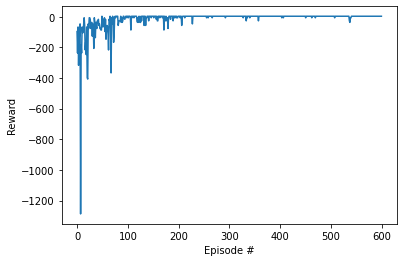

In [250]:
env =  GridworldEnv2()
env.reset()
epsilon = 1
alpha = 1
q = np.array([[0 for _ in range(actions_count)] for _ in range(states_count)])
start_time = time.time()
episodes_rewards = []
for _ in range(EPISODES_COUNT):
    env.reset()
    episode_rewards = []
    state = 44
    while True:
        best_action = np.argmax(q[state])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action = np.random.choice(range(actions_count), p=probs)
        state_prim, reward, _, _ = env.step(action)
        best_action = np.argmax(q[state_prim])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        action_2 = np.random.choice(range(actions_count), p=probs)
        state_zeg, reward_2, _, _ = env.step(action_2)
        episode_rewards.append(reward)
        best_action = np.argmax(q[state_zeg])
        probs = [epsilon / actions_count for _ in range(actions_count)]
        probs[best_action] += (1-epsilon)
        expected_q = 0
        for a in range(actions_count):
            expected_q += probs[a]*q[state_zeg][a]
        q[state][action] += (alpha * (reward + discount_factor * reward_2 + (discount_factor**2) * expected_q - q[state][action]))
        state = state_prim
        if reward == FINAL_STATE_REWARD:
            break
    episodes_rewards.append(np.sum(episode_rewards))
    epsilon *= 0.99
    alpha *= 0.9999999
end_time = time.time()
total_time = end_time - start_time
print("Total time: {}".format(total_time))
print(episodes_rewards)
print("Two-step Expected SARSA average reward: {}".format(np.average(episodes_rewards)))
episdoes_number = [i for i in range(EPISODES_COUNT)]
plt.plot(episdoes_number, episodes_rewards)
plt.xlabel("Episode #")
plt.ylabel("Reward")
plt.show()

As you see, our hypotesis is accepted by simulation result. It learns after less than 100 episodes and get good rewards very fast.